# XGBoost classifier

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import xgboost
import numpy as np
import cupy as cp
import pandas as pd
from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from hyperopt import fmin, tpe, hp, anneal, Trials

import configuration as config

/mnt/arkk/llm_detector/classifier


In [2]:
# Load the raw training data
data_df = pd.read_json(config.COMBINED_SCORED_HANS_DATA_PR_TFIDF)

percent_human_fragments = (len(data_df[data_df['Source'] == 'human']) / len(data_df)) * 100
print(f'Text fragments are {percent_human_fragments}% human\n')

data_df.info()
print()
data_df.head()

Text fragments are 73.34373800263734% human

<class 'pandas.core.frame.DataFrame'>
Index: 119818 entries, 0 to 119817
Data columns (total 12 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Fragment length (tokens)                 119818 non-null  int64  
 1   Dataset                                  119818 non-null  object 
 2   Source                                   119818 non-null  object 
 3   String                                   119818 non-null  object 
 4   Perplexity                               119818 non-null  float64
 5   Cross-perplexity                         119818 non-null  float64
 6   Perplexity ratio score                   119818 non-null  float64
 7   Perplexity ratio Kullback-Leibler score  119730 non-null  float64
 8   Human TF-IDF                             119818 non-null  float64
 9   Synthetic TF-IDF                         119818 non-null  float

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score
0,229,cc_news-falcon7,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,0.971085,1.146746,0.846818,1.498175,-4.154520,-3.375011,5.869343,0.022587
1,267,cc_news-falcon7,human,specialty chemicals company reported $0.65 ear...,1.185710,1.238428,0.957431,0.189686,-4.439004,-3.483652,7.568930,0.020660
2,290,cc_news-falcon7,human,reposted in violation of US and international ...,1.212603,1.270731,0.954256,0.198995,-4.464970,-3.488189,7.768490,0.020301
3,156,cc_news-falcon7,human,one has issued a buy rating to the company. Th...,1.285289,1.332959,0.964237,0.174337,-4.764929,-3.801451,8.253517,0.019349
4,231,cc_news-falcon7,human,specialty chemicals company’s stock valued at ...,1.272878,1.475141,0.862886,1.220695,-4.019600,-3.178213,6.056150,0.022488


In [3]:
# Split the data into features and labels
labels = data_df['Source']
features = data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels)
encoded_labels = label_encoder.transform(labels)
print(f'Labels: {list(zip(labels[:10], encoded_labels[:10]))}')

Labels: [('human', 0), ('human', 0), ('human', 0), ('human', 0), ('human', 0), ('human', 0), ('synthetic', 1), ('synthetic', 1), ('human', 0), ('human', 0)]


In [4]:
# Split into training and test sets
features_train_df, features_test_df, labels_train, labels_test = train_test_split(features, encoded_labels, test_size = 0.3, random_state = 0)

# Keep dataframe copy for easy manipulation later and make a numpy copy for training
# without the dataset or string columns
features_train = features_train_df.drop(['Dataset', 'String'], axis = 1).to_numpy()
features_test = features_test_df.drop(['Dataset', 'String'], axis = 1).to_numpy()
# labels_train = labels_train_df.to_numpy()
# labels_test = labels_test_df.to_numpy()


print(f'Training data: {len(labels_train)} examples')
print(f'Test data: {len(features_test)} examples')
print()
print('Training features:')
print(features_train_df.info())
print()
print('Training labels:')
print(labels_train)

Training data: 83872 examples
Test data: 35946 examples

Training features:
<class 'pandas.core.frame.DataFrame'>
Index: 83872 entries, 48609 to 68268
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (tokens)                 83872 non-null  int64  
 1   Dataset                                  83872 non-null  object 
 2   String                                   83872 non-null  object 
 3   Perplexity                               83872 non-null  float64
 4   Cross-perplexity                         83872 non-null  float64
 5   Perplexity ratio score                   83872 non-null  float64
 6   Perplexity ratio Kullback-Leibler score  83808 non-null  float64
 7   Human TF-IDF                             83872 non-null  float64
 8   Synthetic TF-IDF                         83872 non-null  float64
 9   TF-IDF score                             

## Off-the-shelf XGBoost classifier

In [5]:
# Fit model on training data
model = xgboost.XGBClassifier()
model.fit(features_train, labels_train)

# Make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 88.4%



Confusion matrix:
[[24540  1857]
 [ 2307  7242]]

Normalized confusion matrix:
[[0.6826907  0.05166082]
 [0.0641796  0.20146887]]



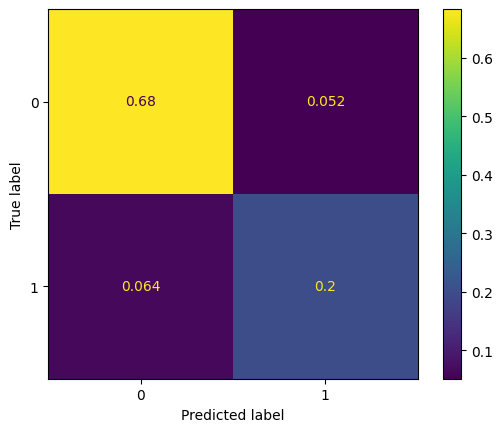

In [6]:
# Calculate confusion matrix
cm = confusion_matrix(labels_test, predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))
print(normalized_cm)
print()

# Plot the confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test, normalize = 'all')

## XGBoost: k-fold cross-validation

In [7]:
# Cross validate the model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)
results = cross_validate(model, features_train, labels_train, cv = kfold, return_train_score = True)

In [8]:
# Fit for real on all training data
model.fit(features_train, labels_train)

# Evaluate on test data
y_pred = model.predict(features_test)
accuracy = accuracy_score(labels_test, predictions)

In [9]:
print('10-fold CV accuracy: %.2f%% (%.3f%%)' % (results['test_score'].mean() * 100, results['test_score'].std() * 100))
print('Hold out test set accuracy: %.2f%%' % (accuracy * 100.0))

10-fold CV accuracy: 88.31% (0.233%)
Hold out test set accuracy: 88.42%


OK, pretty good - we are not over-fitting or just guessing the major class, which is good. For reference, guessing human all the time would give us ~76% accuracy. Let's step it up and see if we can do better.

## XGBoost hyperparameter tuning

In [10]:
def hyperopt_cv(
      params: dict = None, 
      random_state: int = 42, 
      kfolds: int = 10,
      fold_split: float = 0.5,
      features: np.ndarray = None, 
      labels: np.ndarray = None
) -> float:
   
   '''Cross validate an XGBoost classifier with a set of hyperparameters, returns mean CV core'''
    
   # Get the a set of variable parameters from params
   params = {
      'eta': params['eta'],
      # 'gamma': params['gamma'],
      'max_depth': int(params['max_depth']),
      # 'min_child_weight': params['min_child_weight'],
      # 'max_delta_step': int(params['max_delta_step']),
      # 'subsample': int(params['subsample']),
      # 'reg_alpha' : params['reg_alpha'],
      # 'reg_lambda' : params['reg_lambda'],
      'n_estimators': int(params['n_estimators'])
   }

   # Create a new XGB model using the values from params
   model = xgboost.XGBClassifier(device = 'cuda', random_state = random_state, **params)

   # Get number of examples in dataset
   n = labels.shape[0]

   # Set score to zero at start
   score = 0

   # Run k-fold with random samples
   for k in range(kfolds):
      
      # Pick random indices without replacement for data to include in validation set
      validation_indices = np.random.choice(range(n), size = (int(n*fold_split),), replace = False)    
      validation_mask = np.zeros(n, dtype = bool)
      validation_mask[validation_indices] = True
      training_mask = ~validation_mask

      labels_train = labels[training_mask]
      features_train = features[training_mask]
      labels_validation = labels[validation_mask]
      features_validation = features[validation_mask]

      # Move data to GPU
      gpu_features_train = cp.array(features_train)
      gpu_labels_train = cp.array(labels_train)
      gpu_features_validation = cp.array(features_validation)
   
      # Fit the model
      model.fit(gpu_features_train, gpu_labels_train)

      # Make predictions for validation data
      labels_predicted = model.predict(gpu_features_validation)

      # Evaluate predictions, summing score across the folds
      score += accuracy_score(labels_validation, labels_predicted)

   # Return negated mean score for minimization
   return -score / kfolds

In [11]:
%%time

# How many iterations to run
n_iter = 50

# Fix random state
random_state = 42

# Parameter optimization space
space = {
       'eta': hp.uniform('eta', 0.001, 1.0),
       # 'gamma': hp.quniform('gamma', 0, 10, 1),
       'max_depth': hp.quniform('max_depth', 1, 100, 1),
       # 'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
       # 'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1),
       # 'subsample': hp.uniform('subsample', 0, 1),
       # 'reg_alpha': hp.quniform('reg_alpha', 0, 10, 1),
       # 'reg_lambda': hp.uniform('reg_lambda', 0, 10),
       'n_estimators': hp.quniform('n_estimators', 1, 100, 1)
}

# Set up trial logging
trials = Trials()

best = fmin(
       fn = partial(
              hyperopt_cv, 
              features = features_train, 
              labels = labels_train
       ),
       space = space,           # Parameter: value dictionary
       algo = tpe.suggest,      # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,      # Maximum number of iterations
       trials = trials,         # Logging
       rstate = np.random.default_rng(random_state)
)

print()

100%|██████████| 50/50 [07:32<00:00,  9.05s/trial, best loss: -0.883620278519649] 

CPU times: user 8min 44s, sys: 4.59 s, total: 8min 49s
Wall time: 7min 32s


In [12]:
print('Optimized parameters:')
print(f" Learning rate: {best['eta']}")
print(f" Max tree depth: {best['max_depth']}")
print(f" Estimators: {best['n_estimators']}")

# Fit on the complete training set with the winning parameters
model = xgboost.XGBClassifier(
    eta = best['eta'],
    # gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    # min_child_weight = best['min_child_weight'],
    # max_delta_step = int(best['max_delta_step']),
    # subsample = int(best['subsample']),
    # reg_alpha = best['reg_alpha'],
    # reg_lambda = best['reg_lambda'],
    n_estimators = int(best['n_estimators']),
    random_state = random_state,
    device = 'cuda'
)

model.fit(cp.array(features_train), cp.array(labels_train))

# Evaluate on test data
labels_predicted = model.predict(cp.array(features_test))
accuracy = accuracy_score(labels_test, labels_predicted)

Optimized parameters:
 Learning rate: 0.2803060094094926
 Max tree depth: 2.0
 Estimators: 66.0


10-fold CV accuracy: 88.31% (0.233%)
Hold out test set accuracy: 88.26%

Confusion matrix:
[[24592  1805]
 [ 2415  7134]]

Normalized confusion matrix:
[[0.68413732 0.05021421]
 [0.06718411 0.19846436]]



/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [11:13:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


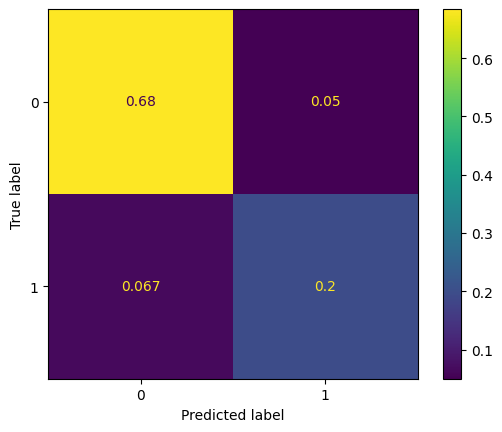

In [13]:
print('10-fold CV accuracy: %.2f%% (%.3f%%)' % (results['test_score'].mean() * 100, results['test_score'].std() * 100))
print('Hold out test set accuracy: %.2f%%' % (accuracy * 100.0))

# Calculate confusion matrix
cm = confusion_matrix(labels_test, labels_predicted)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))
print(normalized_cm)
print()

# Plot the confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test, normalize = 'all')

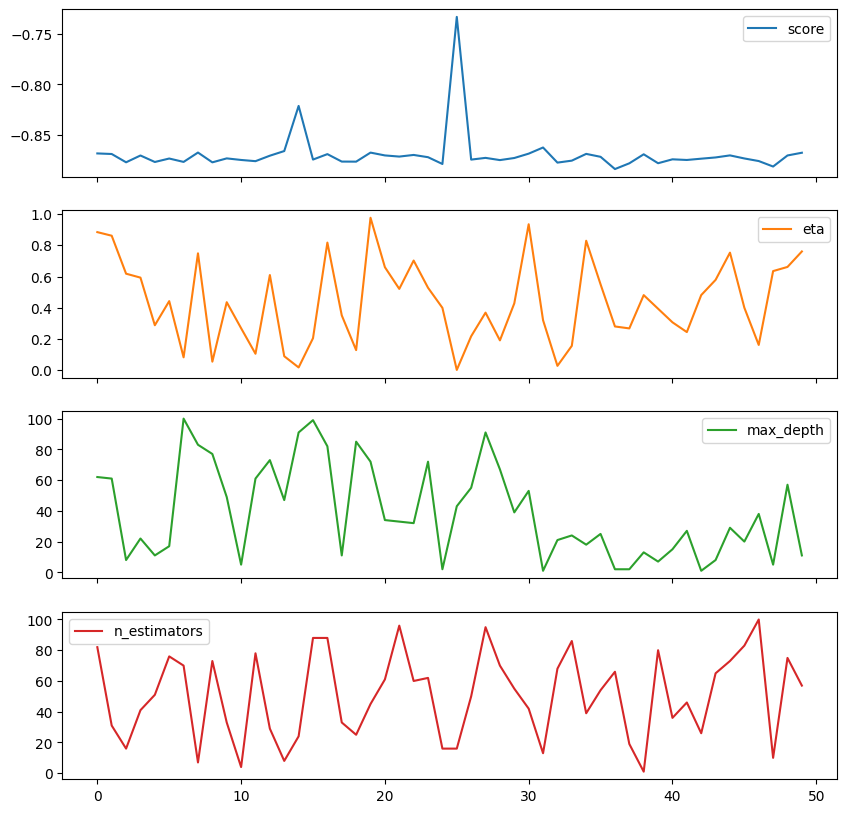

In [14]:
tpe_results = np.array([[
    x['result']['loss'],
    x['misc']['vals']['eta'][0],
    # x['misc']['vals']['gamma'][0],
    x['misc']['vals']['max_depth'][0],
    # x['misc']['vals']['min_child_weight'][0],
    # x['misc']['vals']['max_delta_step'][0],
    # x['misc']['vals']['subsample'][0],
    # x['misc']['vals']['reg_alpha'][0],
    # x['misc']['vals']['reg_lambda'][0],
    x['misc']['vals']['n_estimators'][0],

] for x in trials.trials])

tpe_results_df = pd.DataFrame(
    tpe_results, 
    columns = [
        'score', 
        'eta',
        # 'gamma',
        'max_depth',
        # 'min_child_weight',
        # 'max_delta_step',
        # 'subsample',
        # 'reg_alpha',
        # 'reg_lambda',
        'n_estimators'
    ]
)

optimization_plot = tpe_results_df.plot(subplots = True, figsize = (10, 10))

## Where are we failing?

At this point, it feels like we have hit the limit of what the classifier is capable of. Doesn't seem like we will be able to get past 90% accuracy without changing/improving features and/or data. Let's take a look at the text fragments which are bing miss-classified and see if anything jumps out.

In [15]:
test_error_indices = []
i = 0
n = 1

for features, label, prediction in zip(features_test, labels_test, predictions):

    print(f'\nLabel = {label}, prediction = {prediction}', end = '')

    if label != prediction:
        print(' - error!', end = '')
        test_error_indices.append(i)

    n += 1
    i += 1

print(f'\nHave {len(test_error_indices)} ({round((len(test_error_indices) / len(labels_predicted)) * 100, 1)}%) miss-classed text fragments from the test set')


Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 1
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 0 - error!

Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 0 - error!

Label = 1, prediction = 1
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 1
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 0 - error!

Label = 0, prediction = 1 - error!

Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 0 - error!

Label = 0, prediction = 0
Label = 0, pr

In [16]:
# Recover the miss-classed fragments
errors = []
test_strings = list(features_test_df['String'])

for i in test_error_indices:
    errors.append(test_strings[i])

for error in errors[:10]:
    print(f'{error}\n\n')

and broad investigation of recent reports and allegations and to make whatever changes are required."
SEE ALSO: Here's the latest development in the Cambridge Anal


used to treat epilepsy and bipolar disorder.
Sir Muir Gray, Director of NICE National Clinical


station KWTX, the chapter’s national organization said it was “deeply concerned” with what had happened.
“We deeply regret this incident, and it is completely contrary to all of our values and principles,” the statement read. “We have been in contact with the OU chapter to provide them with our support during this difficult time, and we have spoken to students involved in the incident to encourage them to reach out to help in any way they can.”
“This is clearly a unique incident for us and is not representative of the culture of fraternity and sorority life at OU. For almost a century, our fraternities and sororities have been committed to inclusiveness and equality


with a young son when I discovered the one I'd go on to buy.

Hmm, hard to draw any easy conclusions why these are being miss-classified. Some are short or very low entropy, but many are not. Maybe let's look at our features' distributions in the correctly and incorrectly classed fragments.

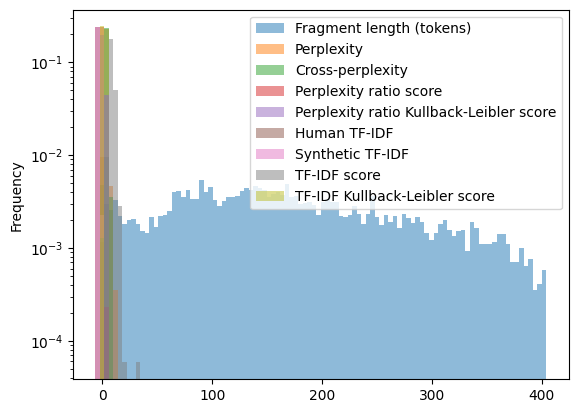

In [17]:
errors = features_test_df.iloc[test_error_indices]
ax = errors.plot.hist(bins=100, alpha=0.5, density=True, log=True)

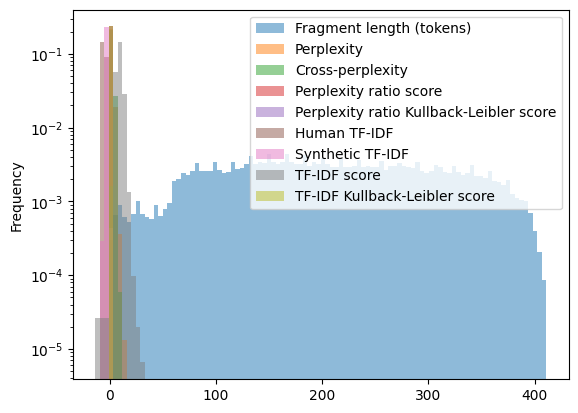

In [18]:
ax = features_test_df.plot.hist(bins=100, alpha=0.5, density=True, log=True)

Yeah, nothing jumps right out at me... Maybe let's just do some general feature checking.

<Figure size 1900x1500 with 0 Axes>

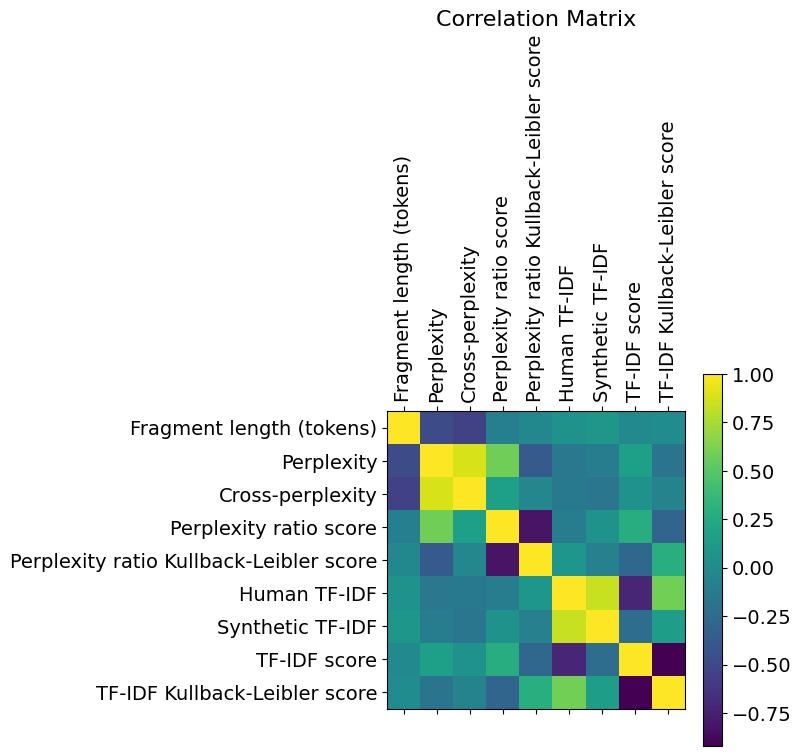

In [19]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(features_test_df.drop(['String', 'Dataset'], axis = 1).corr())
plt.xticks(range(features_test_df.select_dtypes(['number']).shape[1]), features_test_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(features_test_df.select_dtypes(['number']).shape[1]), features_test_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

OK, so we do have some strongly correlated and anti-correlated features. Let's try just removing some of them and see if things improve.

In [20]:
features_train_df.head()

,Fragment length (tokens),Dataset,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score
48609,242,pubmed-llama2-13,patients who could have sustained multiple fra...,2.936899,2.914833,1.007570,0.178316,-5.324861,-4.160877,11.041246,0.013417
27960,52,cc_news-llama2-13,shown above. You really get to appreciate Sing...,3.011737,3.591548,0.838562,1.632757,-4.462330,-3.809650,5.398953,0.022704
40347,176,cc_news-llama2-13,up the advance. Both were hit some 10 yards fr...,3.319357,3.241656,1.023970,0.203512,-4.348078,-3.277246,8.165441,0.019529
71026,195,pubmed-llama2-13,a statistically and clinically meaningful diff...,2.383269,2.680903,0.888980,0.788581,-4.826455,-3.624014,10.161192,0.015153
2241,81,cc_news-falcon7,to relent earlier this week and lifting the ba...,2.779463,2.801158,0.992255,0.162389,-4.947660,-4.008400,8.412067,0.019017


<Figure size 1900x1500 with 0 Axes>

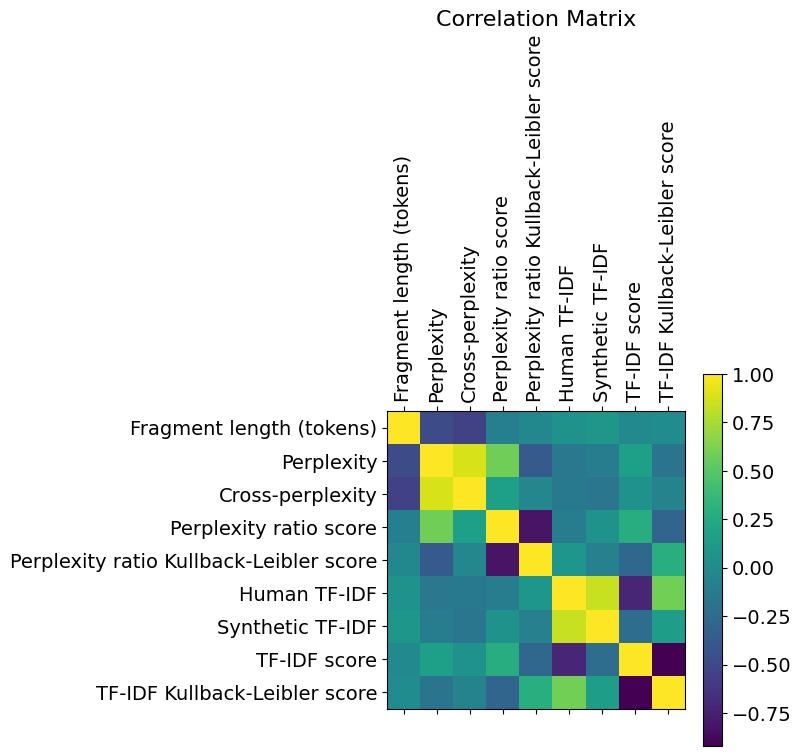

In [21]:
drops = ['Dataset', 'String']#, 'Perplexity', 'Human TF-IDF', 'Perplexity ratio score', 'TF-IDF score', 'Synthetic TF-IDF', 'Cross-perplexity']

trimmed_features_train_df = features_train_df.drop(drops, axis = 1)
trimmed_features_test_df = features_test_df.drop(drops, axis = 1)

f = plt.figure(figsize=(19, 15))
plt.matshow(trimmed_features_test_df.corr())
plt.xticks(range(trimmed_features_test_df.select_dtypes(['number']).shape[1]), trimmed_features_test_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(trimmed_features_test_df.select_dtypes(['number']).shape[1]), trimmed_features_test_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [22]:
# Fit model on training data
model = xgboost.XGBClassifier()
model.fit(trimmed_features_train_df, labels_train)

# Make predictions for test data
y_pred = model.predict(trimmed_features_test_df)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 88.4%


Eh, dropping features doesn't make things convincingly better. Let's try some crack-head stuff, "y'all got any more of them features?"

In [23]:
features = ['Perplexity', 'Cross-perplexity', 'Perplexity ratio score', 'Perplexity ratio Kullback-Leibler score', 'Human TF-IDF', 'Synthetic TF-IDF', 'TF-IDF score', 'TF-IDF Kullback-Leibler score']

for feature in features:
    synthetic_feature = f'{feature} squared'
    data_df[synthetic_feature] = data_df[feature] ** 2

data_df.head()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score,Perplexity squared,Cross-perplexity squared,Perplexity ratio score squared,Perplexity ratio Kullback-Leibler score squared,Human TF-IDF squared,Synthetic TF-IDF squared,TF-IDF score squared,TF-IDF Kullback-Leibler score squared
0,229,cc_news-falcon7,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,0.971085,1.146746,0.846818,1.498175,-4.154520,-3.375011,5.869343,0.022587,0.943006,1.315027,0.717100,2.244530,17.260040,11.390698,34.449184,0.000510
1,267,cc_news-falcon7,human,specialty chemicals company reported $0.65 ear...,1.185710,1.238428,0.957431,0.189686,-4.439004,-3.483652,7.568930,0.020660,1.405907,1.533703,0.916675,0.035981,19.704758,12.135828,57.288697,0.000427
2,290,cc_news-falcon7,human,reposted in violation of US and international ...,1.212603,1.270731,0.954256,0.198995,-4.464970,-3.488189,7.768490,0.020301,1.470406,1.614757,0.910605,0.039599,19.935954,12.167463,60.349443,0.000412
3,156,cc_news-falcon7,human,one has issued a buy rating to the company. Th...,1.285289,1.332959,0.964237,0.174337,-4.764929,-3.801451,8.253517,0.019349,1.651967,1.776779,0.929754,0.030393,22.704546,14.451030,68.120537,0.000374
4,231,cc_news-falcon7,human,specialty chemicals company’s stock valued at ...,1.272878,1.475141,0.862886,1.220695,-4.019600,-3.178213,6.056150,0.022488,1.620219,2.176042,0.744572,1.490095,16.157188,10.101037,36.676958,0.000506


In [24]:
# Split the data into features and labels
labels = data_df['Source']
features = data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels)
encoded_labels = label_encoder.transform(labels)
print(f'Labels: {list(zip(labels[:10], encoded_labels[:10]))}')

# Split into training and test sets
features_train_df, features_test_df, labels_train, labels_test = train_test_split(features, encoded_labels, test_size = 0.3, random_state = 0)

# Keep dataframe copy for easy manipulation later and make a numpy copy for training
# without the dataset or string columns
features_train = features_train_df.drop(['Dataset', 'String'], axis = 1).to_numpy()
features_test = features_test_df.drop(['Dataset', 'String'], axis = 1).to_numpy()

print()
print(features_train_df.head())

Labels: [('human', 0), ('human', 0), ('human', 0), ('human', 0), ('human', 0), ('human', 0), ('synthetic', 1), ('synthetic', 1), ('human', 0), ('human', 0)]

       Fragment length (tokens)            Dataset  \
48609                       242   pubmed-llama2-13   
27960                        52  cc_news-llama2-13   
40347                       176  cc_news-llama2-13   
71026                       195   pubmed-llama2-13   
2241                         81    cc_news-falcon7   

                                                  String  Perplexity  \
48609  patients who could have sustained multiple fra...    2.936899   
27960  shown above. You really get to appreciate Sing...    3.011737   
40347  up the advance. Both were hit some 10 yards fr...    3.319357   
71026  a statistically and clinically meaningful diff...    2.383269   
2241   to relent earlier this week and lifting the ba...    2.779463   

       Cross-perplexity  Perplexity ratio score  \
48609          2.914833          

In [25]:
# Fit model on training data
model = xgboost.XGBClassifier()
model.fit(features_train, labels_train)

# Make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 88.3%


OK, apparently sklearn has this built in...

In [26]:
# demonstrate the types of features created
from numpy import asarray
from sklearn.preprocessing import PolynomialFeatures

# Get rid of nan
features.dropna(axis = 1, inplace = True)

# perform a polynomial features transform of the dataset
trans = PolynomialFeatures(degree = 3)
poly_features = trans.fit_transform(features.drop(['Dataset', 'String'], axis = 1))

# Split into training and test sets
features_train, features_test, labels_train, labels_test = train_test_split(poly_features, encoded_labels, test_size = 0.3, random_state = 0)

In [27]:
# Fit model on training data
model = xgboost.XGBClassifier(device = 'cuda')
model.fit(cp.array(features_train), cp.array(labels_train))

# Make predictions for test data
y_pred = model.predict(cp.array(features_test))
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 88.2%


Nope, OK, need to move on here. Looks like there is no easy way to improve... We can revisit this later.